In [80]:
import h5py
import glob
import numpy as np
import pandas as pd
import hdf5plugin
pd.set_option('display.max_rows', 100)  # Adjust the number of rows to show
pd.set_option('display.max_columns', 50)  # Adjust the number of columns to show
from collections import Counter

import matplotlib.pylab as mpl

In [56]:
def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref).values
		


In [83]:
def plot_diffs(statid):
    dir_19 = "/mnt/users/scratch/leo/scratch/converted_v19/long/"
    dir_24 = "/mnt/users/scratch/leo/scratch/converted_v25/long/"

    for var in ["126", "139", "140", "106"]:
        for press in [50000]:
            if var == "126":
                for ba in [{"126": "RASE_bias_estimate"}, {"126": "RISE_bias_estimate"}, {"126": "RAOBCORE_bias_estimate"}, {"126": "RICH_bias_estimate"}]:
                    with h5py.File(glob.glob(dir_19 + "*" + statid + "*.nc")[0], "r") as old_file:
                        old_rts = old_file["recordindices"]["recordtimestamp"][:]
                        old_idx = old_file["recordindices"][var][:-1]
                        old_idx = old_idx[old_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                        press_mask = old_file["observations_table"]['z_coordinate'][old_idx[0]:old_idx[-1]] == press

                        old_ba = old_file["advanced_homogenisation"][ba[var]][old_idx[0]:old_idx[-1]][press_mask]
                        old_dt = old_file["observations_table"]['date_time'][old_idx[0]:old_idx[-1]][press_mask]

                    with h5py.File(glob.glob(dir_24 + "*" + statid + "*.nc")[0], "r") as new_file:
                        new_rts = new_file["recordindices"]["recordtimestamp"][:]
                        new_idx = new_file["recordindices"][var][:-1]
                        new_idx = new_idx[new_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                        press_mask = new_file["observations_table"]['z_coordinate'][new_idx[0]:new_idx[-1]] == press

                        new_ba = new_file["advanced_homogenisation"][ba[var]][new_idx[0]:new_idx[-1]][press_mask]
                        new_dt = new_file["observations_table"]['date_time'][new_idx[0]:new_idx[-1]][press_mask]
                    
                    

                    common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                    #Count occurrences of each timestamp in the original arrays
                    new_counts = Counter(new_dt)
                    old_counts = Counter(old_dt)
                    # Compare counts for the common timestamps
                    common_counts = {t: (new_counts[t], old_counts[t]) for t in common_times}
                    mismatched_counts = {t: c for t, c in common_counts.items() if c[0] != c[1]}
                    print("Mismatched Counts:", mismatched_counts)


                    new_dt, unique_new_indices = np.unique(new_dt, return_index=True)
                    new_ba = new_ba[unique_new_indices]

                    common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                    

                    # Mask to filter datasets by the common times
                    mask1 = np.isin(new_dt, common_times)
                    mask2 = np.isin(old_dt, common_times)

                    # Apply masks to get the filtered datasets
                    filtered_data1 = new_ba[mask1]
                    filtered_data2 = old_ba[mask2]
                    filtered_times = common_times

                    diff = filtered_data1 - filtered_data2

                    mpl.plot(seconds_to_datetime(filtered_times), diff, label="new - old")
                    mpl.title(statid +'_'+ ba[var] +'_'+ str(press))
                    mpl.grid()
                    mpl.legend()
                    mpl.show()
                    mpl.close()
            else:
                ba = {"36":"humidity_bias_estimate", "139":"wind_bias_estimate", "140":"wind_bias_estimate", "106":"wind_bias_estimate", "38": "humidity_bias_estimate" }
                with h5py.File(glob.glob(dir_19 + "*" + statid + "*.nc")[0], "r") as old_file:
                    old_rts = old_file["recordindices"]["recordtimestamp"][:]
                    old_idx = old_file["recordindices"][var][:-1]
                    old_idx = old_idx[old_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                    press_mask = old_file["observations_table"]['z_coordinate'][old_idx[0]:old_idx[-1]] == press

                    old_ba = old_file["advanced_homogenisation"][ba[var]][old_idx[0]:old_idx[-1]][press_mask]
                    old_dt = old_file["observations_table"]['date_time'][old_idx[0]:old_idx[-1]][press_mask]

                with h5py.File(glob.glob(dir_24 + "*" + statid + "*.nc")[0], "r") as new_file:
                    new_rts = new_file["recordindices"]["recordtimestamp"][:]
                    new_idx = new_file["recordindices"][var][:-1]
                    new_idx = new_idx[new_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                    press_mask = new_file["observations_table"]['z_coordinate'][new_idx[0]:new_idx[-1]] == press

                    new_ba = new_file["advanced_homogenisation"][ba[var]][new_idx[0]:new_idx[-1]][press_mask]
                    new_dt = new_file["observations_table"]['date_time'][new_idx[0]:new_idx[-1]][press_mask]
                

                common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                #Count occurrences of each timestamp in the original arrays
                new_counts = Counter(new_dt)
                old_counts = Counter(old_dt)
                # Compare counts for the common timestamps
                common_counts = {t: (new_counts[t], old_counts[t]) for t in common_times}
                mismatched_counts = {t: c for t, c in common_counts.items() if c[0] != c[1]}
                print("Mismatched Counts:", mismatched_counts)

                new_dt, unique_new_indices = np.unique(new_dt, return_index=True)
                new_ba = new_ba[unique_new_indices]
                
                common_times = np.intersect1d(old_dt, new_dt)

                # Mask to filter datasets by the common times
                mask1 = np.isin(new_dt, common_times)
                mask2 = np.isin(old_dt, common_times)

                # Apply masks to get the filtered datasets
                filtered_data1 = new_ba[mask1]
                filtered_data2 = old_ba[mask2]
                filtered_times = common_times
                diff = filtered_data1 - filtered_data2

                mpl.plot(seconds_to_datetime(filtered_times), diff, label="new - old")
                mpl.title(statid +'_'+ var + "_" + ba[var] +'_'+ str(press))
                mpl.grid()
                mpl.legend()
                mpl.show() 
                mpl.close()      


Mismatched Counts: {}


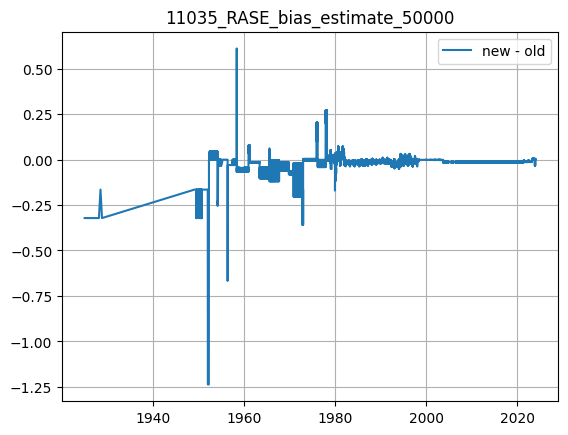

Mismatched Counts: {}


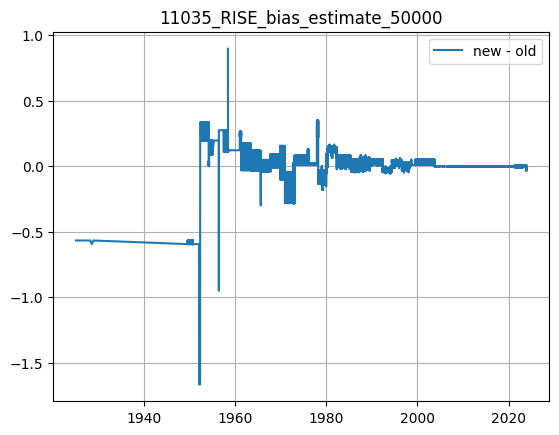

Mismatched Counts: {}


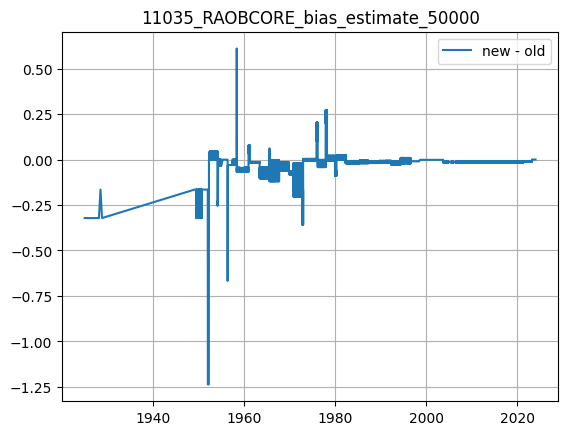

Mismatched Counts: {}


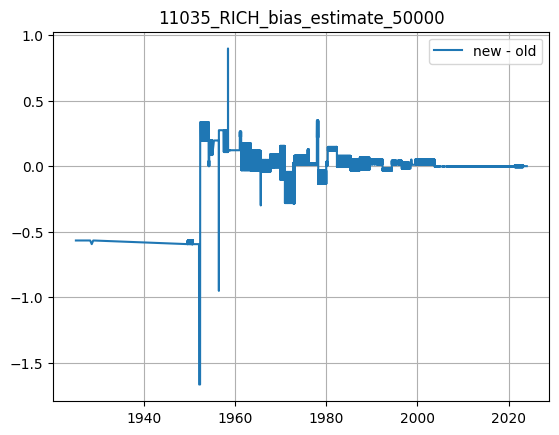

Mismatched Counts: {}


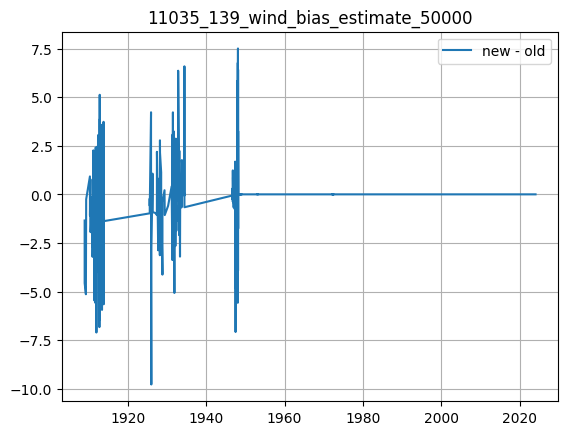

Mismatched Counts: {}


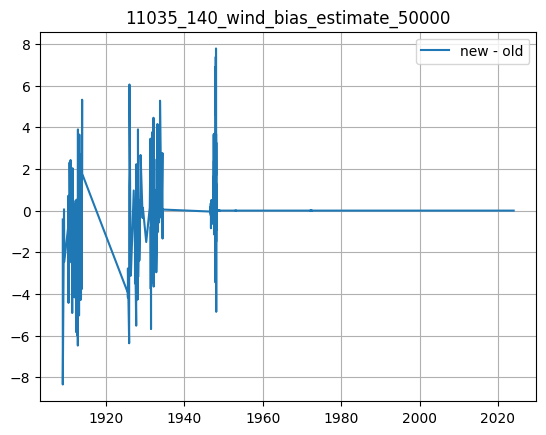

Mismatched Counts: {}


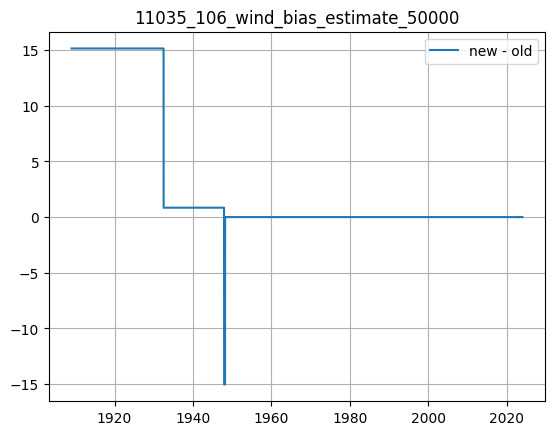

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


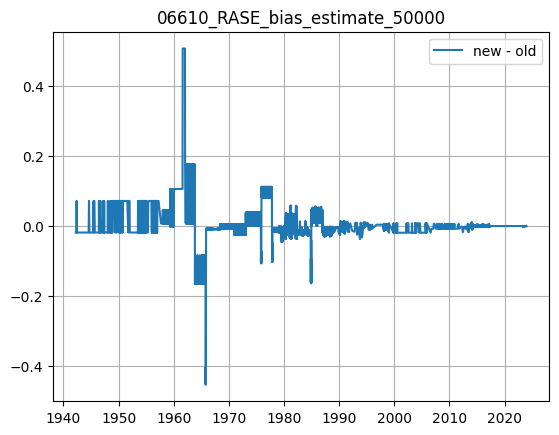

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


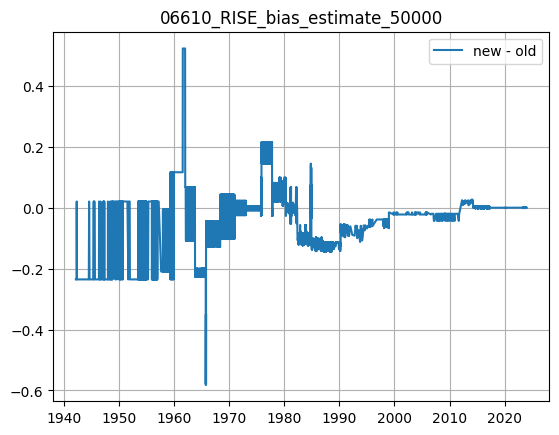

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


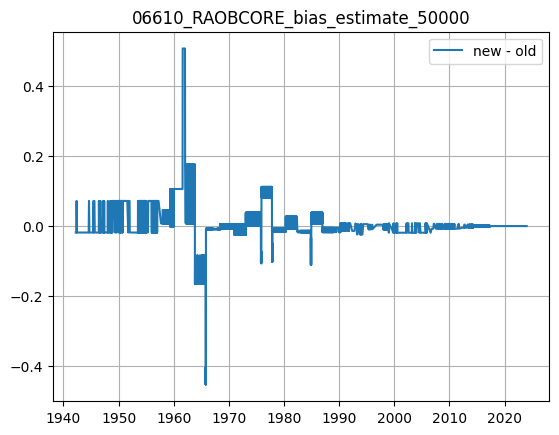

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


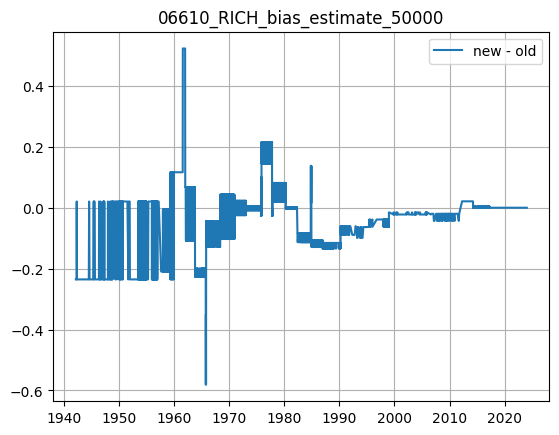

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


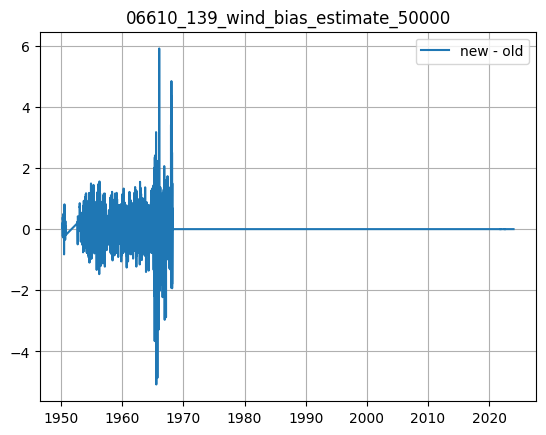

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


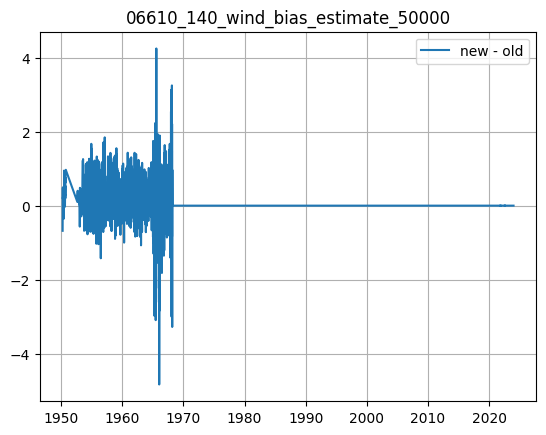

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2966365800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3124132200: (2, 1), 3629055600: (2, 1), 3660591600: (2, 1), 3692214000: (2, 1)}


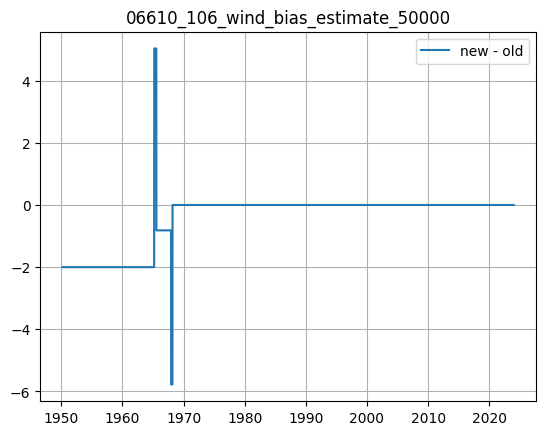

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


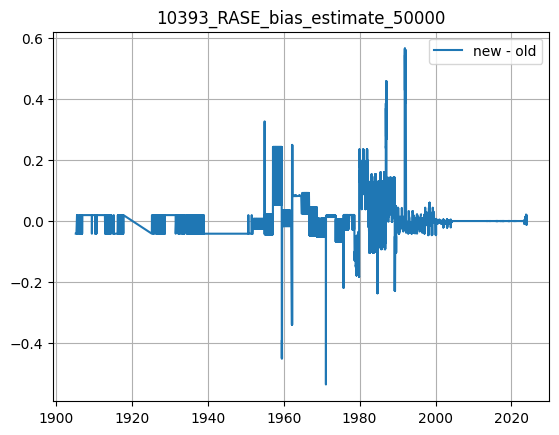

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


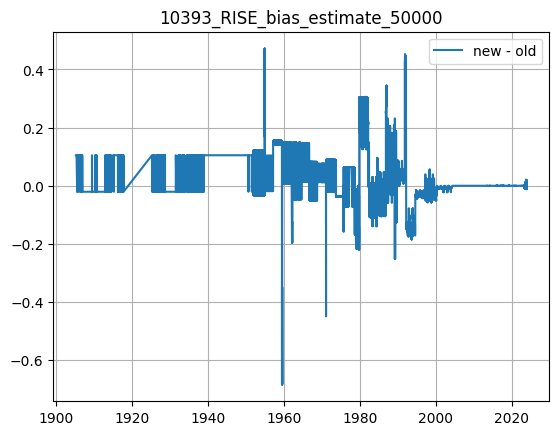

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


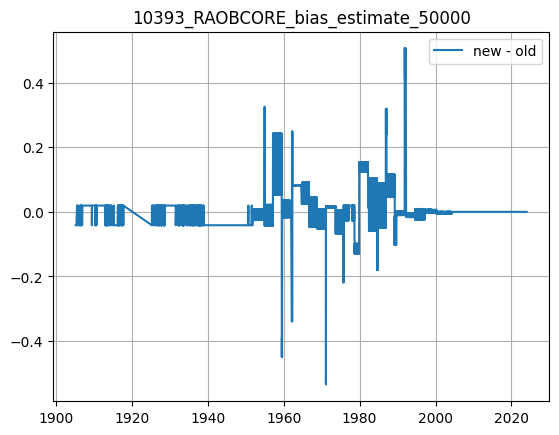

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


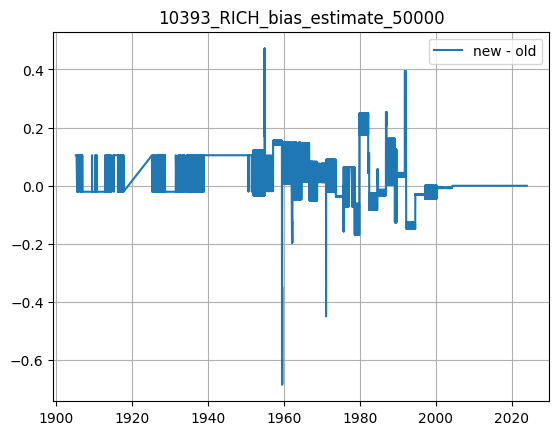

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


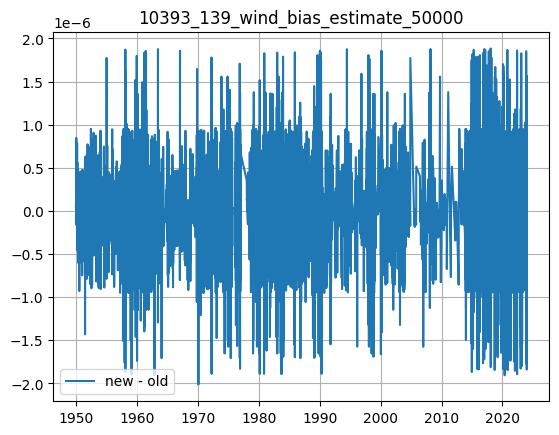

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


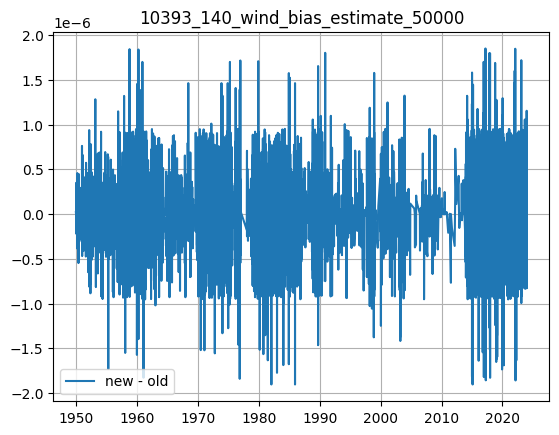

Mismatched Counts: {2871671400: (2, 1), 2903207400: (2, 1), 2934829800: (2, 1), 2966365800: (2, 1), 2997901800: (2, 1), 3029437800: (2, 1), 3061060200: (2, 1), 3092596200: (2, 1), 3124132200: (2, 1), 3629054751: (2, 1), 3660590783: (2, 1)}


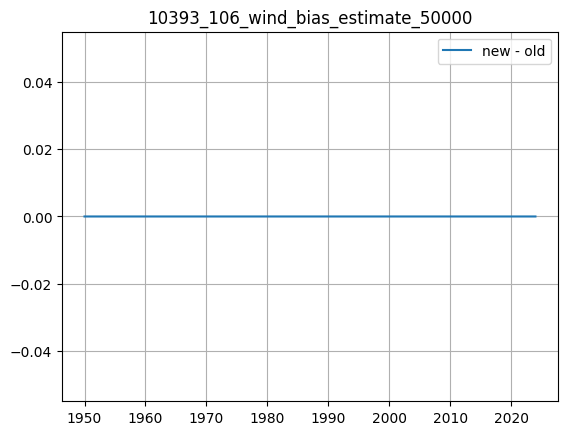

In [84]:
for i in ["11035", "06610", "10393"]:
    plot_diffs(i)